## LSTM Encoder Decoder Model to Forecast Bus Demand

### Imports

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras import Sequential
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

2023-02-14 08:58:56.954278: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 08:58:57.251832: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-14 08:58:57.251858: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-14 08:58:58.320818: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

### Reading Data

In [2]:
data = pd.read_csv("data/preprocessed_data.csv", engine="c")

### Utils

In [3]:
def split_categories(df, column):
    """
    A method that splits dataframe into separate dataframes according to contained groups of given column
    :param df: dataframe
    :param column: string column name that includes groups
    :return: list of dataframes
    """
    df_list = []
    groups = df.groupby(df[column])
    for i in range(len(groups)):
        df_list.append(groups.get_group(i))
    return df_list

In [4]:
def split_sequence(sequence, look_back, forecast_horizon):
    """
    A method that creates time series sequences using given parameters
    :param sequence: dataframe
    :param look_back: number of value(s) as input
    :param forecast_horizon: number of value(s) as target
    :return: numpy arrays for input and target
    """
    X, y = list(), list()
    for i in range(len(sequence)):
        lag_end = i + look_back
        forecast_end = lag_end + forecast_horizon
        if forecast_end > len(sequence):
            break
        seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [5]:
def evaluate_forecast(y_test, yhat):
    """
    Evaluation metrics with tensorflow
    :param y_test: real target values of test values
    :param yhat: predicted target values from test values
    :return: evaluation scores
    """
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test,yhat)
    print('mae:', mae)
    mse = mse_(y_test,yhat)
    print('mse:', mse)
    mape = mape_(y_test,yhat)
    print('mape:', mape)

### Model

**Model Preparations**

In [6]:
early_stopping_callback = EarlyStopping(
                         monitor="val_loss",
                         min_delta=0.005,
                         patience=10,
                         mode="min"
                        )
rlrop_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.2, mode="min", patience=3, min_lr=0.01)

In [7]:
municipalities = split_categories(data, "municipality_id")

In [8]:
forecast_start = "2017-08-05 06"
forecast_end = "2017-08-19 16"
working_hours_start = 7
working_hours_end = 16
LOOK_BACK = 7
FORECAST_RANGE = 1

In [9]:
epochs = 100
batch_size = 32
validation = 0.1

**Train**

In [13]:
models = []
histories = []
X_trains = []
y_trains = []
X_tests = []
y_tests = []

for i in municipalities:
    df = i.copy()[["timestamp", "usage"]].set_index("timestamp")

    train_df = df.loc[:"2017-08-05 06:00:00"]
    test_df = df.loc["2017-08-05 06:00:00":]

    n_features = len(train_df.columns)

    split_train = split_sequence(train_df, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
    X_trains.append(split_train[0])
    y_trains.append(split_train[1])
    split_test = split_sequence(test_df, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
    X_tests.append(split_test[0])
    y_tests.append(split_test[1])

    model_enc_dec = Sequential()
    model_enc_dec.add(LSTM(50, activation='relu', input_shape=(LOOK_BACK, n_features)))
    model_enc_dec.add(RepeatVector(FORECAST_RANGE))
    model_enc_dec.add(LSTM(50, activation='relu', return_sequences=True))
    model_enc_dec.add(TimeDistributed(Dense(n_features)))
    model_enc_dec.add(Activation(activation='relu'))
    model_enc_dec.compile(optimizer='rmsprop', loss='mae', run_eagerly=True)
    histories.append(model_enc_dec.fit(split_train[0], split_train[1], epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, rlrop_callback], verbose=1))
    models.append(model_enc_dec)

Epoch 1/100
18/18 [==============================] - 1s 43ms/step - loss: 488.1383 - val_loss: 298.5952 - lr: 0.0010
Epoch 2/100
18/18 [==============================] - 1s 44ms/step - loss: 224.0757 - val_loss: 111.1559 - lr: 0.0010
Epoch 3/100
18/18 [==============================] - 1s 45ms/step - loss: 145.1399 - val_loss: 65.9399 - lr: 0.0010
Epoch 4/100
18/18 [==============================] - 1s 40ms/step - loss: 129.3469 - val_loss: 71.3987 - lr: 0.0010
Epoch 5/100
18/18 [==============================] - 1s 43ms/step - loss: 110.4442 - val_loss: 46.6808 - lr: 0.0010
Epoch 6/100
18/18 [==============================] - 1s 43ms/step - loss: 104.8603 - val_loss: 59.6061 - lr: 0.0010
Epoch 7/100
18/18 [==============================] - 1s 42ms/step - loss: 103.1279 - val_loss: 60.0013 - lr: 0.0010
Epoch 8/100
18/18 [==============================] - 1s 42ms/step - loss: 96.2489 - val_loss: 59.7723 - lr: 0.0010
Epoch 9/100
18/18 [==============================] - 1s 46ms/step - los

**Predict**

In [14]:
yhats = []
for i in range(len(models)):
    yhats.append(models[i].predict(X_tests[i]))

5/5 [==============================] - 0s 18ms/step


**Visualize**

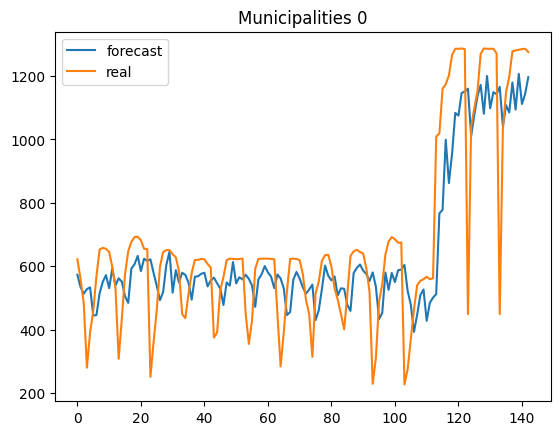

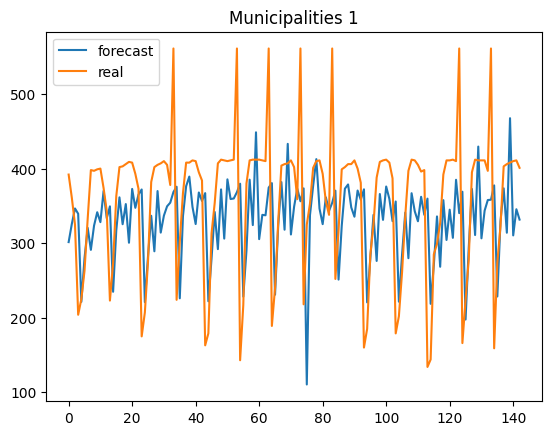

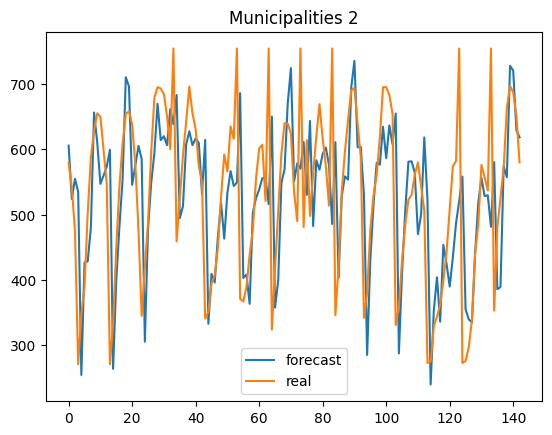

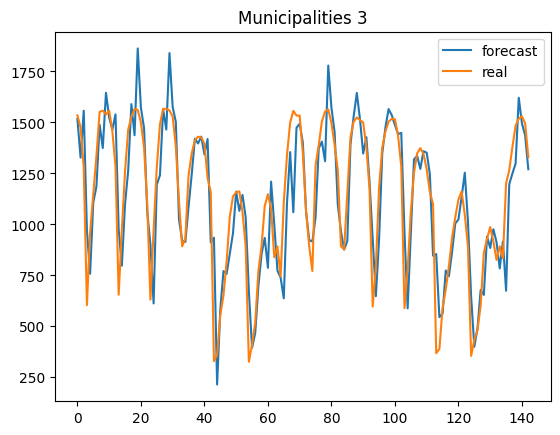

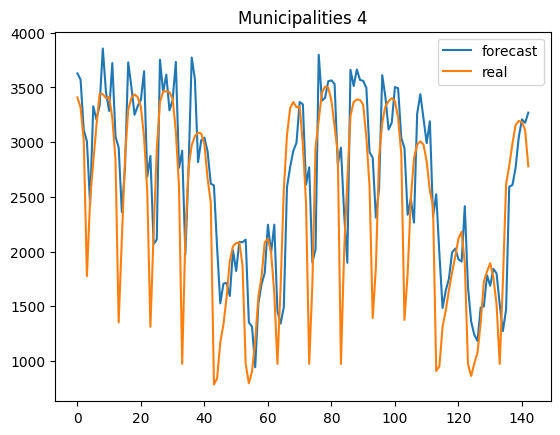

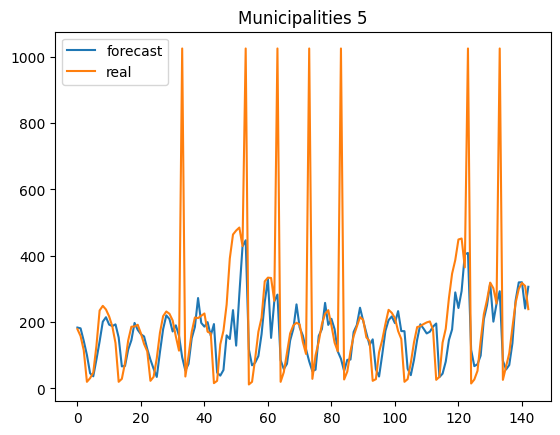

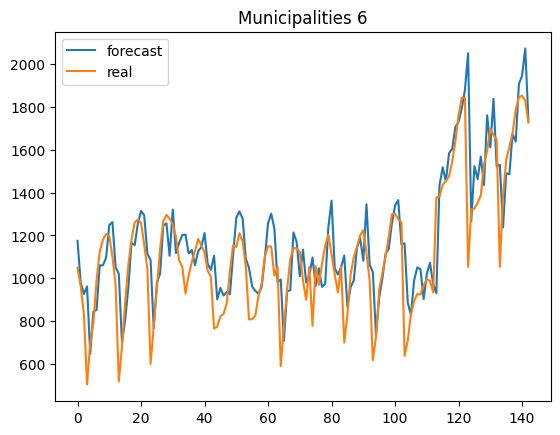

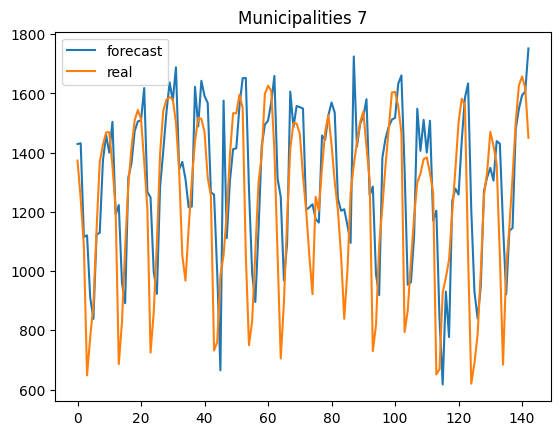

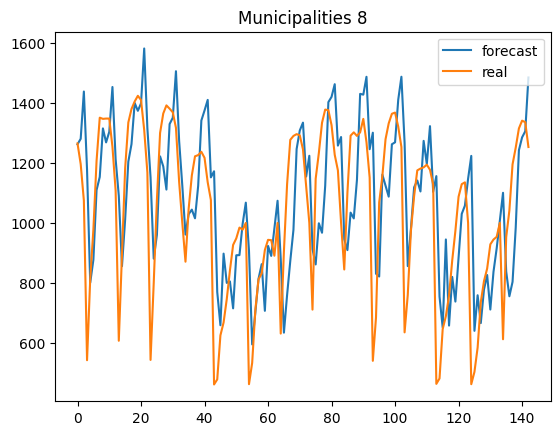

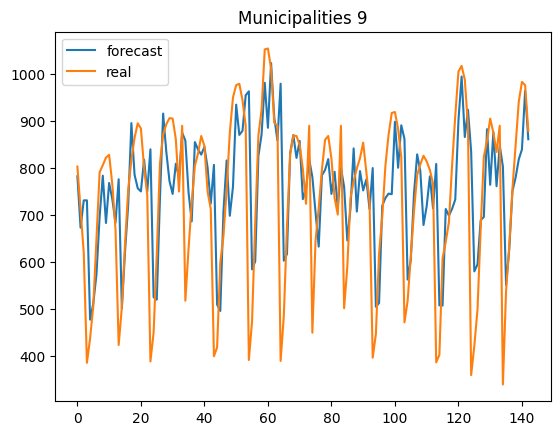

In [15]:
import matplotlib.pyplot as plt
for i in range(len(models)):
    plt.plot(yhats[i][:,0], label='forecast')
    plt.plot(y_tests[i][:,0], label='real')
    plt.title(f"Municipalities {i}")
    plt.legend()
    plt.show()

**Scores**

In [16]:
for i in range(len(models)):
    print(f"Municipality {i}")
    evaluate_forecast(y_tests[i][:, 0], yhats[i][:, 0])
    print("-------------")

Municipality 0
mae: tf.Tensor(115.89158, shape=(), dtype=float32)
mse: tf.Tensor(25974.53, shape=(), dtype=float32)
mape: tf.Tensor(22.238914, shape=(), dtype=float32)
-------------
Municipality 1
mae: tf.Tensor(70.4816, shape=(), dtype=float32)
mse: tf.Tensor(8571.193, shape=(), dtype=float32)
mape: tf.Tensor(23.600285, shape=(), dtype=float32)
-------------
Municipality 2
mae: tf.Tensor(80.38532, shape=(), dtype=float32)
mse: tf.Tensor(12673.022, shape=(), dtype=float32)
mape: tf.Tensor(17.69253, shape=(), dtype=float32)
-------------
Municipality 3
mae: tf.Tensor(128.99384, shape=(), dtype=float32)
mse: tf.Tensor(30728.336, shape=(), dtype=float32)
mape: tf.Tensor(14.94469, shape=(), dtype=float32)
-------------
Municipality 4
mae: tf.Tensor(395.95773, shape=(), dtype=float32)
mse: tf.Tensor(340088.84, shape=(), dtype=float32)
mape: tf.Tensor(25.181568, shape=(), dtype=float32)
-------------
Municipality 5
mae: tf.Tensor(85.44425, shape=(), dtype=float32)
mse: tf.Tensor(36320.516, s

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
def evaluate_forecast_sklearn(y_test, yhat):
    """
    Evaluation metrics with tensorflow
    :param y_test: real target values of test values
    :param yhat: predicted target values from test values
    :return: evaluation scores
    """
    mae = mean_absolute_error(y_test,yhat)
    print('mae:', mae)
    mse = mean_squared_error(y_test,yhat)
    print('mse:', mse)
    mape = mean_absolute_percentage_error(y_test,yhat)
    print('mape:', mape)

In [18]:
for i in range(len(models)):
    print(f"Municipality {i}")
    evaluate_forecast_sklearn(y_tests[i][:, 0], yhats[i][:, 0])
    print("-------------")

Municipality 0
mae: 115.89158393486399
mse: 25974.527580356164
mape: 0.2223891324899309
-------------
Municipality 1
mae: 70.48159406257398
mse: 8571.192514940369
mape: 0.2360028330957398
-------------
Municipality 2
mae: 80.38531875906753
mse: 12673.021715905683
mape: 0.17692531380837406
-------------
Municipality 3
mae: 128.99384169500746
mse: 30728.335851623226
mape: 0.14944689922403256
-------------
Municipality 4
mae: 395.95773938111586
mse: 340088.862698595
mape: 0.25181566373305964
-------------
Municipality 5
mae: 85.44425602626133
mse: 36320.51427109251
mape: 0.753520904871321
-------------
Municipality 6
mae: 118.12071865173671
mse: 31565.319075871466
mape: 0.12631174343843618
-------------
Municipality 7
mae: 158.04748873766206
mse: 48557.94970193113
mape: 0.16051642002784486
-------------
Municipality 8
mae: 165.51009633405874
mse: 53138.78364132117
mape: 0.20314600296664723
-------------
Municipality 9
mae: 97.52660172469132
mse: 23115.323960638627
mape: 0.1769237461112862